In [1]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Random
using BenchmarkTools

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.
┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1278
┌ Warning: Package GraphPPL does not have ReactiveMP in its dependencies:
│ - If you have GraphPPL checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GraphPPL
└ Loading ReactiveMP into GraphPPL from project dependency, future 

In [241]:
@model function gaussian_mixture_model(n)
    
    s ~ Dirichlet([ 1.0, 1.0, 1.0 ])
    
    m1 ~ NormalMeanVariance(-10.0, 1e3)
    w1 ~ Gamma(0.01, 100.0)
    
    m2 ~ NormalMeanVariance(0.0, 1e3)
    w2 ~ Gamma(0.01, 100.0)
    
    m3 ~ NormalMeanVariance(10.0, 1e3)
    w3 ~ Gamma(0.01, 100.0)
    
    z = randomvar(n)
    y = datavar(Float64, n)
    
    for i in 1:n
        z[i] ~ Categorical(s) where { q = MeanField() }
        y[i] ~ NormalMixture(z[i], (m1, m2, m3), (w1, w2, w3)) where { q = MeanField() }
    end
    
    return s, m1, w1, m2, w2, m3, w3, z, y
end

gaussian_mixture_model (generic function with 1 method)

In [242]:
using Random

In [243]:
function inference(data)
    n = length(data)
    model, (s, m1, w1, m2, w2, m3, w3, z, y) = gaussian_mixture_model(n);
    
    mswitch = Vector{Marginal}()
    mm1 = Vector{Marginal}()
    mm2 = Vector{Marginal}()
    mm3 = Vector{Marginal}()
    mw1 = Vector{Marginal}()
    mw2 = Vector{Marginal}()
    mw3 = Vector{Marginal}()
    
    fe = Vector{Float64}()
    
    fe_scheduler = PendingScheduler()
    
    m1sub = subscribe!(getmarginal(m1), (ms) -> push!(mm1, ms))
    m2sub = subscribe!(getmarginal(m2), (ms) -> push!(mm2, ms))
    m3sub = subscribe!(getmarginal(m3), (ms) -> push!(mm3, ms))
    w1sub = subscribe!(getmarginal(w1), (ms) -> push!(mw1, ms))
    w2sub = subscribe!(getmarginal(w2), (ms) -> push!(mw2, ms))
    w3sub = subscribe!(getmarginal(w3), (ms) -> push!(mw3, ms))
    switchsub = subscribe!(getmarginal(s), (ms) -> push!(mswitch, ms))
    
    fesub = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (f) -> push!(fe, f))
    
    setmarginal!(s, vague(Dirichlet, 3))
    setmarginal!(m1, NormalMeanVariance(-10.0, 1e3))
    setmarginal!(m2, NormalMeanVariance(0.0, 1e3))
    setmarginal!(m3, NormalMeanVariance(10.0, 1e3))
    setmarginal!(w1, vague(Gamma))
    setmarginal!(w2, vague(Gamma))
    setmarginal!(w3, vague(Gamma))
    
    for i in 1:75
        update!(y, data)
        release!(fe_scheduler)
    end
    
    unsubscribe!(fesub)
    unsubscribe!(switchsub)
    unsubscribe!(m1sub)
    unsubscribe!(m2sub)
    unsubscribe!(m3sub)
    unsubscribe!(w1sub)
    unsubscribe!(w2sub)
    unsubscribe!(w3sub)
    
    return mswitch, mm1[5:end], mm2[5:end], mm3[5:end], mw1[5:end], mw2[5:end], mw3[5:end], fe
end

inference (generic function with 1 method)

In [244]:
n = 2500

Random.seed!(124)

switch = [ 1/4, 1/2, 1/4 ]
z      = rand(Categorical(switch), n)
y      = Vector{Float64}(undef, n)

μ1 = -40.0
μ2 = 5.0
μ3 = +40.0
w  = 1.777

dists = [
    Normal(μ1, sqrt(inv(w))),
    Normal(μ2, sqrt(inv(w))),
    Normal(μ3, sqrt(inv(w)))
]

for i in 1:n
    y[i] = rand(dists[z[i]])
end

In [245]:
@time mswitch, mm1, mm2, mm3, mw1, mw2, mw3, fe = inference(y);

 23.627181 seconds (82.86 M allocations: 4.419 GiB, 11.74% gc time)


In [246]:
using Plots

dim(d) = (a) -> map(r -> r[d], a)

dim (generic function with 1 method)

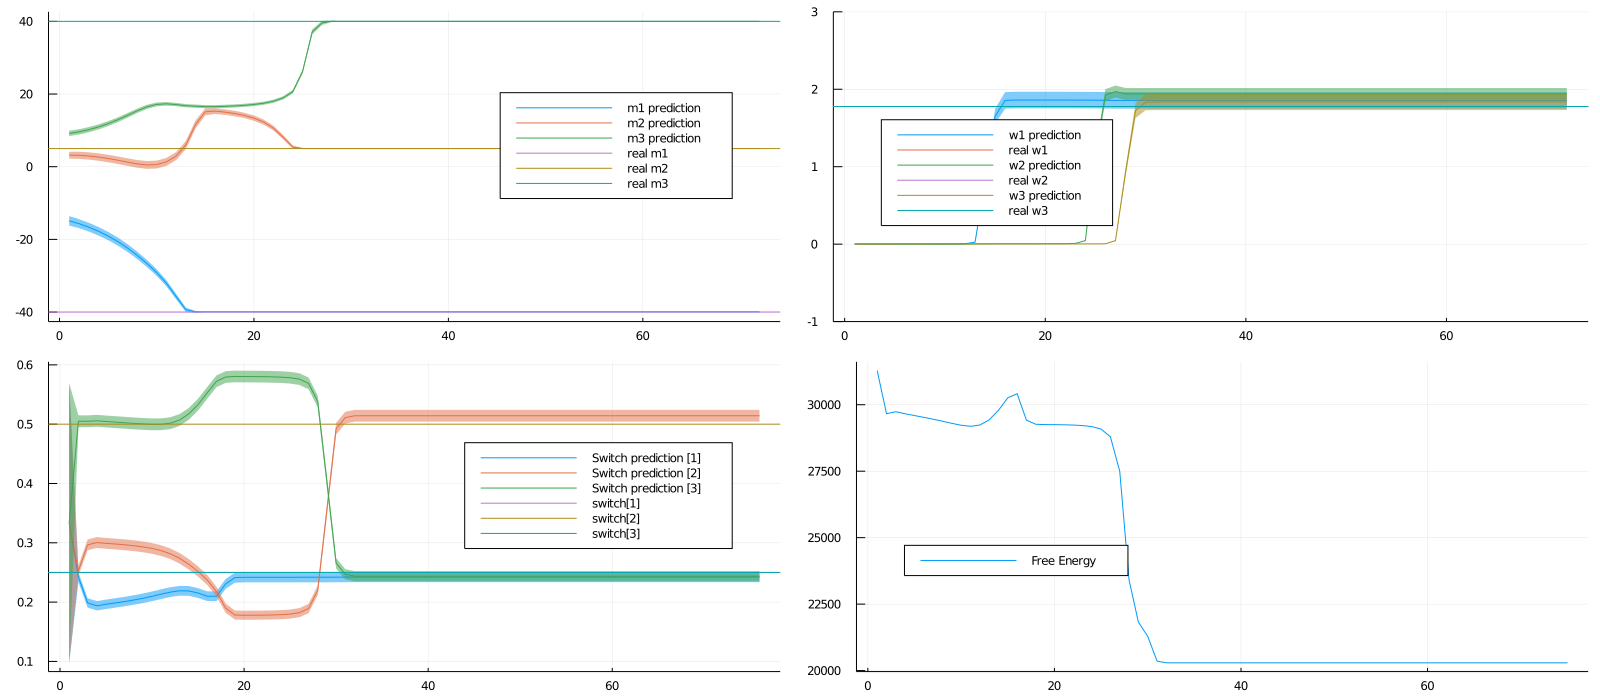

In [247]:
mp = plot(mean.(mm1), ribbon = var.(mm1) .|> sqrt, label = "m1 prediction")
mp = plot!(mean.(mm2), ribbon = var.(mm2) .|> sqrt, label = "m2 prediction")
mp = plot!(mean.(mm3), ribbon = var.(mm3) .|> sqrt, label = "m3 prediction")
mp = plot!(mp, [ μ1 ], seriestype = :hline, label = "real m1")
mp = plot!(mp, [ μ2 ], seriestype = :hline, label = "real m2")
mp = plot!(mp, [ μ3 ], seriestype = :hline, label = "real m3")

wp = plot(mean.(mw1), ribbon = var.(mw1) .|> sqrt, label = "w1 prediction", legend = :bottomleft, ylim = (-1, 3))
wp = plot!(wp, [ w ], seriestype = :hline, label = "real w1")
wp = plot!(wp, mean.(mw2), ribbon = var.(mw2) .|> sqrt, label = "w2 prediction")
wp = plot!(wp, [ w ], seriestype = :hline, label = "real w2")
wp = plot!(wp, mean.(mw3), ribbon = var.(mw3) .|> sqrt, label = "w3 prediction")
wp = plot!(wp, [ w ], seriestype = :hline, label = "real w3")

swp = plot(mean.(mswitch) |> dim(1), ribbon = var.(mswitch) |> dim(1) .|> sqrt, label = "Switch prediction [1]")
swp = plot!(swp, mean.(mswitch) |> dim(2), ribbon = var.(mswitch) |> dim(2) .|> sqrt, label = "Switch prediction [2]")
swp = plot!(swp, mean.(mswitch) |> dim(3), ribbon = var.(mswitch) |> dim(3) .|> sqrt, label = "Switch prediction [3]")

swp = plot!(swp, [ switch[1] ], seriestype = :hline, label = "switch[1]")
swp = plot!(swp, [ switch[2] ], seriestype = :hline, label = "switch[2]")
swp = plot!(swp, [ switch[3] ], seriestype = :hline, label = "switch[3]")

fep = plot(fe, label = "Free Energy", legend = :bottomleft)

plot(mp, wp, swp, fep, layout = @layout([ a b; c d ]), size = (1600, 700))